# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"

    def __init__(self, eta = 0.001, max_iter = 1000, C = 1.0, tol = 1e-5, random_state = 42, zero_init = False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed = random_state)
        self.zero_init = zero_init
        self.loss = np.array([])
        self.actual_iter_count = 0

    def get_sigmoid(self, X, weights):
        return 1 / (1 + np.exp(-X @ weights))

    def get_loss(self, x, weights, y):
        return np.mean(
            np.log(1 + np.exp(-(x @ weights) * y))
        ) + np.linalg.norm(weights) / (2 * self.C)

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])  # a constant feature is included to handle intercept
        num_samples = X_ext.shape[0]
        num_features = X_ext.shape[1]

        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low = -weight_threshold,
                                                      high = weight_threshold,
                                                      size = num_features)  # random weight initialization
        #y = y.reshape(-1, 1)
        #self.weights_ = self.weights_.reshape(1, -1)

        for i in range(self.max_iter):
            self.actual_iter_count = i + 1
            delta = 0
            for j in range(num_samples):
                delta += y[j] * X_ext[j] * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext[j] * y[j]))))
            delta = delta / num_samples
            delta = delta - self.weights_ / self.C
            self.loss = np.append(self.loss,
                                  [i,
                                   self.get_loss(X_ext, self.weights_, y),
                                   np.linalg.norm(self.eta * delta, ord = 2)])

            if np.linalg.norm(delta) < self.tol:
                break

            self.weights_ += self.eta * delta

        self.loss = self.loss.reshape(-1, 3)
        return self

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else:
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        prediction = np.array([])
        for i in range(X.shape[0]):
            prediction = np.append(prediction, 1 if self.predict_proba(X[i, :].reshape(1, -1)) > 0.5 else -1)
        return prediction

In [5]:
from sklearn import datasets
from sklearn import metrics

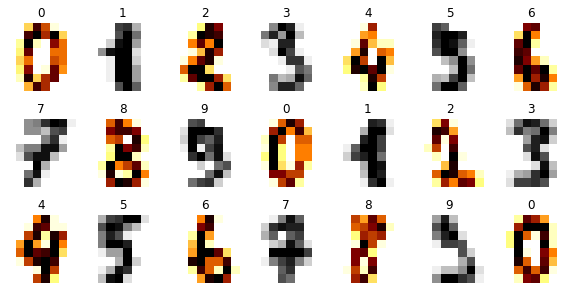

In [6]:
X, y = datasets.load_digits(n_class = 10, return_X_y = True)

_, axes = plt.subplots(nrows = 3, ncols = 7, figsize = (10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap = plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(1437, 64)

(360, 64)

(1437, 1)

(360, 1)

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize = 'true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

    return metrics.accuracy_score(y_pred = clf.predict(X_train), y_true = y_train), metrics.accuracy_score(
        y_pred = clf.predict(X_test), y_true = y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter = 1, zero_init = True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([3.1000e-06, 0.0000e+00, 4.1800e-05, 5.4770e-04, 2.2130e-04,
                                              4.8750e-04, 1.3577e-03, 5.9780e-04, 5.6400e-05, -7.0000e-07,
                                              1.6910e-04, 2.5190e-04, -4.3700e-04, 3.6190e-04, 1.0049e-03,
                                              4.2280e-04, 2.5700e-05, 3.0000e-07, -1.1500e-05, -7.2440e-04,
                                              -2.6200e-04, 8.7540e-04, 4.1540e-04, -8.4200e-05, -5.2000e-06,
                                              0.0000e+00, -2.2160e-04, -5.7130e-04, 9.8570e-04, 1.3507e-03,
                                              5.0210e-04, -1.7050e-04, -1.0000e-06, 0.0000e+00, -6.7810e-04,
                                              -1.0515e-03, -4.4500e-05, 3.7160e-04, 4.2100e-04, -8.1800e-05,
                                              0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
                                              1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
                                              -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
                                              -3.9560e-04, -1.7700e-05, -3.0000e-07, 2.6800e-05, 6.3920e-04,
                                              1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]),
                   atol = 1e-5)

In [14]:
model = CustomLogisticRegression()

D:\Data\Python\3.10.2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


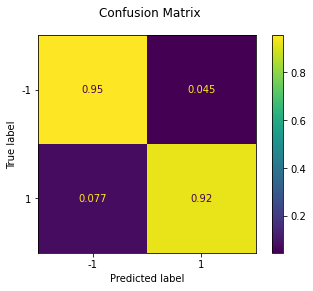

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

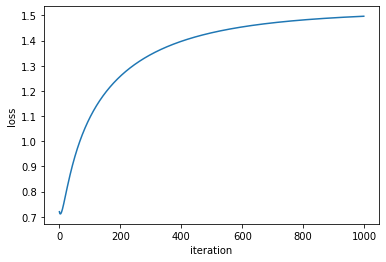

In [17]:
plt.plot(model.loss[:, 0], model.loss[:, 1])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

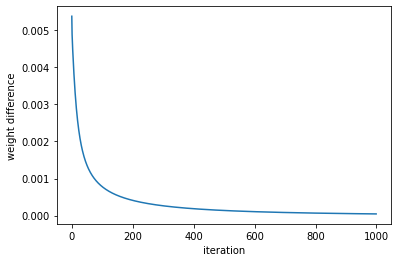

In [18]:
plt.plot(model.loss[:, 0], model.loss[:, 2])
plt.xlabel('iteration')
plt.ylabel('weight difference')
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [19]:
import pandas

logistic_rates = pd.DataFrame({
    'learning_rate': 1 / 10 ** np.arange(4)}
)
logistic_rates

,learning_rate
0,1.000
1,0.100
2,0.010
3,0.001


In [20]:
def fit_evaluate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    return metrics.accuracy_score(y_pred = y_train_pred, y_true = y_train), metrics.accuracy_score(
        y_pred = y_test_pred, y_true = y_test)

In [21]:
def fit_evaluate_metric(y_test, y_test_pred):
    return metrics.accuracy_score(y_pred = y_train_pred, y_true = y_train)

In [22]:
logistic_rates['model'] = logistic_rates.apply(
    lambda row: CustomLogisticRegression(eta = row['learning_rate']).fit(X_train, y_train),
    axis = 1)
logistic_rates = logistic_rates.join(logistic_rates.apply(
    lambda row: fit_evaluate_metrics(y_train, row['model'].predict(X_train), y_test, row['model'].predict(X_test)),
    axis = 1,
    result_type = 'expand'))
logistic_rates.rename(columns = {0: "train", 1: "test"}, inplace = True)
logistic_rates['iter'] = logistic_rates['model'].apply(lambda x: x.actual_iter_count)
logistic_rates.drop('model', axis = 1, inplace = True)
logistic_rates

C:\Users\aliaksei.karaliou\AppData\Local\Temp\ipykernel_20444\2602925069.py:65: RuntimeWarning: overflow encountered in exp
  delta += y[j] * X_ext[j] * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext[j] * y[j]))))
C:\Users\aliaksei.karaliou\AppData\Local\Temp\ipykernel_20444\2602925069.py:36: RuntimeWarning: overflow encountered in exp
  np.log(1 + np.exp(-(x @ weights) * y))
C:\Users\aliaksei.karaliou\AppData\Local\Temp\ipykernel_20444\2602925069.py:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X @ weights))


,learning_rate,train,test,iter
0,1.000,0.496868,0.491667,1000
1,0.100,0.545581,0.527778,1000
2,0.010,0.773138,0.752778,1000
3,0.001,0.910926,0.938889,1000


**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [23]:
## your code

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

D:\Data\Python\3.10.2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


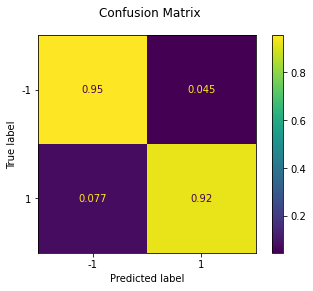

D:\Data\Python\3.10.2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


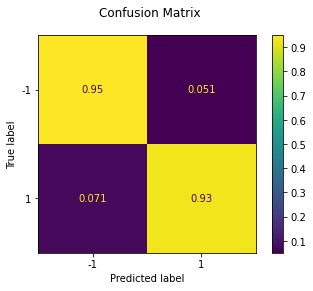

(0.9116214335421016, 0.9388888888888889)

In [24]:
fit_evaluate(CustomLogisticRegression(), X_train, y_train, X_test, y_test)
fit_evaluate(CustomLogisticRegression(zero_init = True), X_train, y_train, X_test, y_test)

In our example there is no big sense between zero and random initialization, but random initialization can be useful in preventing preoverfitting, when initial weights already overfit the model

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [25]:
import pandas as pd


class CustomKNeighborsClassifier:
    _estimator_type = "classifier"

    def __init__(self, n_neighbors = 5, weights = 'uniform', eps = 1e-9):
        """K-Nearest Neighbors classifier.

        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps

    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance
                between i'th row from the X and j'th row from the Y.
        """
        result = np.array([])
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                result = np.append(result, np.sqrt((X[i][0] - Y[j][0]) ** 2 + (X[i][1] - Y[j][1]) ** 2))
        return result.reshape(X.shape[0], Y.shape[0])

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        df = pd.DataFrame({
            'y': y,
            'weights': weights
        })
        res = df.groupby('y')['weights'].sum()

        arr = np.array([])
        for i in self.classes_:
            arr = np.append(arr, res.loc[i])

        return arr

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)

            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / P

            display(pd.DataFrame(P).shape)

            # <your code>
            pass

        else:
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")

    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [26]:
model = CustomKNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0, 1], [1, 1]]),
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])),
                   np.array([2, 4, 0]))

In [29]:
#X, y = datasets.load_digits(n_class = 10, return_X_y = True)
#
#_, axes = plt.subplots(nrows = 3, ncols = 7, figsize = (10, 5))
#for ax, image, label in zip(axes.flatten(), X, y):
#    ax.set_axis_off()
#    ax.imshow(image.reshape((8, 8)), cmap = plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
#    ax.set_title(label)
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [30]:
#model.fit(X_train, y_train)
#knn.fit(X_train, list(map(str, y_train)));

In [31]:
#knn.predict_proba(X_test)

In [32]:
#assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [33]:
#train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [34]:
#assert train_acc == 1
#assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [35]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [36]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [125]:
PATH = "./data/"

In [126]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [127]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

In [128]:
def percentage_column(df: pd.DataFrame, sumColumn, calculateColumn):
    return df.groupby(sumColumn)[calculateColumn].apply(lambda x: 100 * x / float(x.sum()))

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [129]:
display(data.groupby('Sex').size())
display(data.groupby('Sex').size() / data.shape[0])

Sex
female    43886
male      56114
dtype: int64

Sex
female    0.43886
male      0.56114
dtype: float64

We see that there were total 43886 women (43.9%) and 56114 men (56.1%)

Let look at survival rate

In [130]:
survived_sex_data = data.groupby(['Sex', 'Survived']).size().reset_index(name = 'Count')
survived_sex_data

,Sex,Survived,Count
0,female,0,12660
1,female,1,31226
2,male,0,44566
3,male,1,11548


<AxesSubplot:xlabel='Sex', ylabel='Count'>

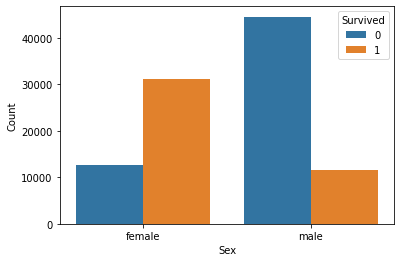

In [131]:
sns.barplot(x = "Sex", y = "Count", hue = "Survived", data = survived_sex_data)

In [132]:
survived_sex_data['Percentage'] = percentage_column(survived_sex_data, 'Sex', 'Count')
survived_sex_data

,Sex,Survived,Count,Percentage
0,female,0,12660,28.847468
1,female,1,31226,71.152532
2,male,0,44566,79.420465
3,male,1,11548,20.579535


[Text(0, 0, '71.1525'), Text(0, 0, '20.5795')]

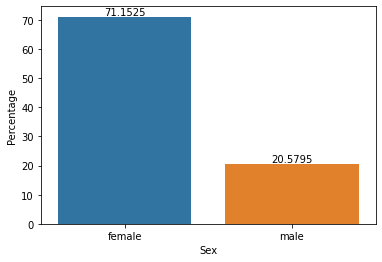

In [133]:
survived_sex_plot = sns.barplot(x = "Sex", y = "Percentage",
                                data = survived_sex_data[survived_sex_data['Survived'] == 1])
survived_sex_plot.bar_label(survived_sex_plot.containers[0])

We see that 71.15 of all women survived and ony 20.58% of all men

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [134]:
data[data['Survived'] == 1]['Age'].agg(['mean', 'median'])

mean      40.553799
median    43.000000
Name: Age, dtype: float64

We see, that mean age for survived people is 40.5 years old, and median is 43 years old

In [135]:
data[data['Survived'] == 0]['Age'].agg(['mean', 'median'])

mean      36.708695
median    36.000000
Name: Age, dtype: float64

We see, that mean age for survived people is 36.7 years old, and median is 36 years old

Let build a plot of survival depending on age

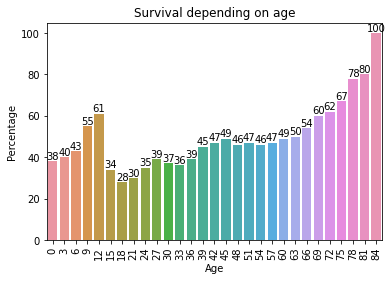

In [136]:
age_group = 3
survived_age_grouped_data = data.groupby(
    [pd.cut(data['Age'], np.arange(90 / age_group) * age_group), 'Survived']).size().rename(
    'Count').reset_index()

survived_age_grouped_data['Percentage'] = percentage_column(survived_age_grouped_data, 'Age', 'Count')
survived_age_grouped_data = survived_age_grouped_data[
    (survived_age_grouped_data['Survived'] == 1) & (survived_age_grouped_data['Percentage'].notna())]
survived_age_grouped_data['Age'] = survived_age_grouped_data['Age'].apply(
    lambda col: pd.Categorical(col).codes * age_group)
survived_age_grouped_data['Percentage'] = survived_age_grouped_data['Percentage'].apply(lambda x: int(x))

survived_age_plot = sns.barplot(x = survived_age_grouped_data['Age'], y = survived_age_grouped_data['Percentage'])
survived_age_plot.bar_label(survived_age_plot.containers[0])
plt.title('Survival depending on age')
plt.xticks(rotation = 90)
plt.show()

We see, that children and old men has better chance for survival. The worse survivors are yound age

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

#### Passenger class

In [137]:
survived_pclass_data = data.groupby(['Pclass', 'Survived']).size().reset_index(name = 'Count')
survived_pclass_data

,Pclass,Survived,Count
0,1,0,12739
1,1,1,17576
2,2,0,13622
3,2,1,15057
4,3,0,30865
5,3,1,10141


<AxesSubplot:xlabel='Pclass', ylabel='Count'>

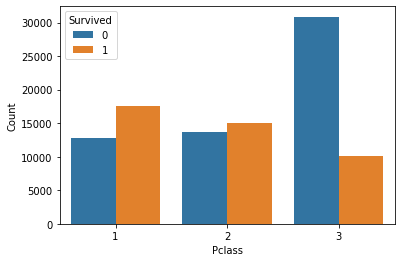

In [138]:
sns.barplot(x = "Pclass", y = "Count", hue = "Survived", data = survived_pclass_data)

We see, that better class leads to better surviving rate. Let's analyze it more

In [139]:
survived_pclass_data['Percentage'] = percentage_column(survived_pclass_data, 'Pclass', 'Count')
survived_pclass_data

,Pclass,Survived,Count,Percentage
0,1,0,12739,42.022101
1,1,1,17576,57.977899
2,2,0,13622,47.498169
3,2,1,15057,52.501831
4,3,0,30865,75.269473
5,3,1,10141,24.730527


[Text(0, 0, '57.9779'), Text(0, 0, '52.5018'), Text(0, 0, '24.7305')]

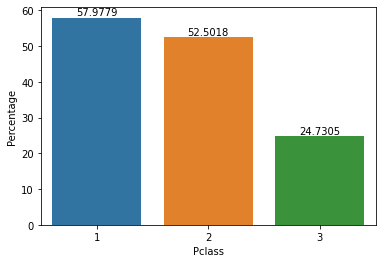

In [140]:
survived_pclass_plot = sns.barplot(x = "Pclass", y = "Percentage",
                                   data = survived_pclass_data[survived_pclass_data['Survived'] == 1])
survived_pclass_plot.bar_label(survived_pclass_plot.containers[0])

We see that among 1st class 58% people survived, 52.5% among 2nd class and only 24.7 among 3rd class. **1st class is the safest**

#### Embarked

In [141]:
survived_embarked_data = data.groupby(['Embarked', 'Survived']).size().reset_index(name = 'Count')
survived_embarked_data

,Embarked,Survived,Count
0,C,0,5518
1,C,1,16669
2,Q,0,2186
3,Q,1,3238
4,S,0,49394
5,S,1,22745


<AxesSubplot:xlabel='Embarked', ylabel='Count'>

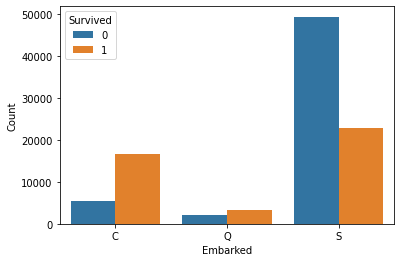

In [142]:
sns.barplot(x = "Embarked", y = "Count", hue = "Survived", data = survived_embarked_data)

We see that among people from Southampton embarking port much more deceased people, among Cherbourg embarking port much more survivors people

In [143]:
survived_embarked_data['Percentage'] = percentage_column(survived_embarked_data, 'Embarked', 'Count')
survived_embarked_data

,Embarked,Survived,Count,Percentage
0,C,0,5518,24.870420
1,C,1,16669,75.129580
2,Q,0,2186,40.302360
3,Q,1,3238,59.697640
4,S,0,49394,68.470591
5,S,1,22745,31.529409


[Text(0, 0, '75.1296'), Text(0, 0, '59.6976'), Text(0, 0, '31.5294')]

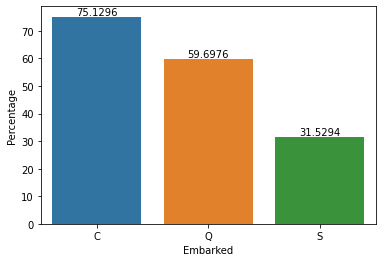

In [144]:
survived_embarked_plot = sns.barplot(x = "Embarked", y = "Percentage",
                                     data = survived_embarked_data[survived_embarked_data['Survived'] == 1])
survived_embarked_plot.bar_label(survived_embarked_plot.containers[0])

We see, that from `Cherbourg` 75.1% people survived and from `Southampton` only 31.5%

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [145]:
data.isnull().sum() / data.shape[0] * 100

PassengerId     0.000
Survived        0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             3.292
SibSp           0.000
Parch           0.000
Ticket          4.623
Fare            0.134
Cabin          67.866
Embarked        0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

#### Solution

In [146]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


#### Age

Let determine surving rate among people with missing age

In [147]:
age_nan_data = data[data['Age'].isna()].groupby('Survived')['Name'].count()
age_nan_data

Survived
0    1936
1    1356
Name: Name, dtype: int64

In [148]:
survived_age_nan = age_nan_data[1] / age_nan_data.sum()
survived_age_nan * 100

41.19076549210207

We see, that 41% of such person was survived. If we look at our age distribution graph, similar surving has people from 39 to 45 age. Let choose 41 years old and fill this missing value by it to not to change correlation

In [149]:
data['Age'] = data['Age'].fillna(41)
data_test['Age'] = data_test['Age'].fillna(41)

In [150]:
data.isnull().sum() / data.shape[0] * 100

PassengerId     0.000
Survived        0.000
Pclass          0.000
Name            0.000
Sex             0.000
Age             0.000
SibSp           0.000
Parch           0.000
Ticket          4.623
Fare            0.134
Cabin          67.866
Embarked        0.250
dtype: float64

#### Ticket

It can be useful to analyze ticket field and extract number from it. If absense - let return 0

In [151]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'constant', fill_value = 'no-ticket', add_indicator = True)
imputer_df = pd.DataFrame(imputer.fit_transform(pd.DataFrame(data['Ticket'])))

data['Ticket'] = pd.Series(imputer_df[0])
data['Ticket_Missing'] = pd.Series(imputer_df[1])

In [152]:
imputer_test = SimpleImputer(strategy = 'constant', fill_value = 'no-ticket', add_indicator = True)
imputer_df_test = pd.DataFrame(imputer_test.fit_transform(pd.DataFrame(data_test['Ticket'])))
data_test['Ticket'] = imputer_df_test[0]
data_test['Ticket_Missing'] = imputer_df_test[1]

In [153]:
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Missing
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,False
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,False
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,False
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,False
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q,False
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S,False
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S,False
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C,False


In [154]:
import re

regex = re.compile('\d+')
data['Ticket'] = data['Ticket'].fillna('none')
data['Ticket_Number'] = data['Ticket'].apply(lambda x: regex.findall(x)[0] if regex.findall(x) else 0)
data.drop('Ticket', axis = 1, inplace = True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_Missing,Ticket_Number
0,0,1,1,"Oconnor, Frankie",male,41.00,2,0,27.14,C12239,S,False,209245
1,1,0,3,"Bryan, Drew",male,41.00,0,0,13.35,NaN,S,False,27323
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,71.29,NaN,S,False,457703
3,3,0,3,"Kramer, James",male,19.00,0,0,13.04,NaN,S,False,10866
4,4,1,3,"Bond, Michael",male,25.00,0,0,7.76,NaN,S,False,427635
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,14.86,D17243,C,False,15008
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,11.15,NaN,S,False,13273
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,9.95,NaN,S,True,0
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,30.92,NaN,S,False,458654


In [155]:
data_test['Ticket'] = data_test['Ticket'].fillna('none')
data_test['Ticket_Number'] = data_test['Ticket'].apply(lambda x: regex.findall(x)[0] if regex.findall(x) else 0)
data_test.drop('Ticket', axis = 1, inplace = True)

In [156]:
data.isnull().sum() / data.shape[0] * 100

PassengerId        0.000
Survived           0.000
Pclass             0.000
Name               0.000
Sex                0.000
Age                0.000
SibSp              0.000
Parch              0.000
Fare               0.134
Cabin             67.866
Embarked           0.250
Ticket_Missing     0.000
Ticket_Number      0.000
dtype: float64

#### Fare

Fare is skipped very rare, so, let fill it with mean value 

In [157]:
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
data_test['Fare'] = data_test['Fare'].fillna(data['Fare'].mean())

In [158]:
data.isnull().sum() / data.shape[0] * 100

PassengerId        0.000
Survived           0.000
Pclass             0.000
Name               0.000
Sex                0.000
Age                0.000
SibSp              0.000
Parch              0.000
Fare               0.000
Cabin             67.866
Embarked           0.250
Ticket_Missing     0.000
Ticket_Number      0.000
dtype: float64

#### Embarked

Let look at `Embarked` column:

In [159]:
data['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

We see that 'Embarked' is categorial feature. So, let fill missing data with `N` category, which not exists yet

In [160]:
data['Embarked'] = data['Embarked'].fillna('N')
data['Embarked'].value_counts()
data_test['Embarked'] = data_test['Embarked'].fillna('N')

In [161]:
data.isnull().sum() / data.shape[0] * 100

PassengerId        0.000
Survived           0.000
Pclass             0.000
Name               0.000
Sex                0.000
Age                0.000
SibSp              0.000
Parch              0.000
Fare               0.000
Cabin             67.866
Embarked           0.000
Ticket_Missing     0.000
Ticket_Number      0.000
dtype: float64

#### Cabin

Let look at cabin values

In [162]:
data['Cabin'].unique()

array(['C12239', nan, 'A7253', ..., 'D12975', 'F12072', 'D17243'],
      dtype=object)

We see that values are specified as pattern: letter and 4-5 digits. Let verify it:

In [163]:
pd.Series(data['Cabin'].dropna().unique()).str.match('^\w\d{4,5}$').value_counts()

True    26992
dtype: int64

We see, that we are right. Let split this column, to letter and number

Let use imputer to fill empty cabin number values

In [164]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 'N0000', add_indicator = True)
imputer_df = pd.DataFrame(imputer.fit_transform(pd.DataFrame(data['Cabin'])))
data['Cabin'] = pd.Series(imputer_df[0])
data['Cabin_Missing'] = pd.Series(imputer_df[1])

In [165]:
imputer = SimpleImputer(strategy = 'constant', fill_value = 'N0000', add_indicator = True)
imputer_df_test = pd.DataFrame(imputer.fit_transform(pd.DataFrame(data_test['Cabin'])))
data_test['Cabin'] = pd.Series(imputer_df_test[0])
data_test['Cabin_Missing'] = pd.Series(imputer_df_test[1])

In [166]:
data['Cabin_Missing'].isnull().sum()

0

In [167]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_Missing,Ticket_Number,Cabin_Missing
0,0,1,1,"Oconnor, Frankie",male,41.00,2,0,27.14,C12239,S,False,209245,False
1,1,0,3,"Bryan, Drew",male,41.00,0,0,13.35,N0000,S,False,27323,True
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,71.29,N0000,S,False,457703,True
3,3,0,3,"Kramer, James",male,19.00,0,0,13.04,N0000,S,False,10866,True
4,4,1,3,"Bond, Michael",male,25.00,0,0,7.76,N0000,S,False,427635,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,14.86,D17243,C,False,15008,False
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,11.15,N0000,S,False,13273,True
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,9.95,N0000,S,True,0,True
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,30.92,N0000,S,False,458654,True


In [168]:
data['Cabin_Number'] = data['Cabin'].str.replace('^\w', '')
data.drop('Cabin', axis = 1, inplace = True)

C:\Users\aliaksei.karaliou\AppData\Local\Temp\ipykernel_20444\1409212420.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Cabin_Number'] = data['Cabin'].str.replace('^\w', '')


In [169]:
data_test['Cabin_Number'] = data_test['Cabin'].str.replace('^\w', '')
data_test.drop('Cabin', axis = 1, inplace = True)

C:\Users\aliaksei.karaliou\AppData\Local\Temp\ipykernel_20444\417918358.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_test['Cabin_Number'] = data_test['Cabin'].str.replace('^\w', '')


In [170]:
data.isnull().sum() / data.shape[0] * 100

PassengerId       0.0
Survived          0.0
Pclass            0.0
Name              0.0
Sex               0.0
Age               0.0
SibSp             0.0
Parch             0.0
Fare              0.0
Embarked          0.0
Ticket_Missing    0.0
Ticket_Number     0.0
Cabin_Missing     0.0
Cabin_Number      0.0
dtype: float64

Finally, we get rid of all missing values

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let look at our data

Let modify our columns to float view:

In [171]:
data.drop('Name', axis = 1, inplace = True)
data['Sex'] = data['Sex'].apply(lambda s: 1 if s == 'male' else 0)

data = data.join(pd.get_dummies(data['Embarked']))
data.drop('Embarked', axis = 1, inplace = True)

data['Ticket_Missing'] = data['Ticket_Missing'].astype(int)
data['Cabin_Missing'] = data['Cabin_Missing'].astype(int)
data.set_index('PassengerId', inplace = True)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_Missing,Ticket_Number,Cabin_Missing,Cabin_Number,C,N,Q,S
PassengerId,,,,,,,,,,,,,,,
0,1,1,1,41.00,2,0,27.14,0,209245,0,12239,0,0,0,1
1,0,3,1,41.00,0,0,13.35,0,27323,1,0000,0,0,0,1
2,0,3,1,0.33,1,2,71.29,0,457703,1,0000,0,0,0,1
3,0,3,1,19.00,0,0,13.04,0,10866,1,0000,0,0,0,1
4,1,3,1,25.00,0,0,7.76,0,427635,1,0000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,0,62.00,0,0,14.86,0,15008,0,17243,1,0,0,0
99996,0,2,1,66.00,0,0,11.15,0,13273,1,0000,0,0,0,1
99997,0,3,1,37.00,0,0,9.95,1,0,1,0000,0,0,0,1


In [172]:
data_test.drop('Name', axis = 1, inplace = True)
data_test['Sex'] = data_test['Sex'].apply(lambda s: 1 if s == 'male' else 0)

data_test = data_test.join(pd.get_dummies(data_test['Embarked']))
data_test.drop('Embarked', axis = 1, inplace = True)

data_test['Ticket_Missing'] = data_test['Ticket_Missing'].astype(int)
data_test['Cabin_Missing'] = data_test['Cabin_Missing'].astype(int)
data_test.set_index('PassengerId', inplace = True)

In [173]:
y = data.pop('Survived')
x = data

In [174]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [175]:
def make_model(model):
    return Pipeline([
        ('sca', StandardScaler()),
        ('model', model)
    ])

In [176]:
def model_result(model, x_test, y_test):
    return pd.DataFrame({
        'true': y_test,
        'predict': model.predict(x_test)
    })

In [177]:
from sklearn.linear_model import LogisticRegression

log_model = make_model(LogisticRegression(max_iter = 1000, random_state = 42, n_jobs = -1))
log_model.fit(x_train, y_train)

fit_evaluate_metrics(y_train = y_train,
                     y_train_pred = log_model.predict(x_train),
                     y_test = y_test,
                     y_test_pred = log_model.predict(x_test))

(0.7691875, 0.7698)

Try to balance weights of logistic regression

In [178]:
total_count = y_train.shape[0]
weight_0 = y_train.value_counts()[0] / total_count
weight_1 = y_train.value_counts()[1] / total_count

log_balanced_model = make_model(LogisticRegression(max_iter = 5000,
                                                   random_state = 42,
                                                   class_weight = {0: weight_0, 1: weight_1},
                                                   n_jobs = -1))

log_balanced_model.fit(x_train, y_train)

fit_evaluate_metrics(y_train = y_train,
                     y_train_pred = log_balanced_model.predict(x_train),
                     y_test = y_test,
                     y_test_pred = log_balanced_model.predict(x_test))

(0.7641625, 0.76585)

Let try to use polinomial features with logistic regression

In [179]:
from sklearn.preprocessing import PolynomialFeatures


def make_polin_model(model, degree, num_features):
    num_transformer = Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree))
    ])

    transformer = ColumnTransformer(
        transformers = [
            ('numeric_transformer', num_transformer, num_features),
        ])

    return Pipeline([
        ('transformer', transformer),
        ('sca', StandardScaler()),
        ('model', model)
    ])

In [180]:
def pol(x, x_train, y_train, num_features):
    display(x)
    return make_polin_model(LogisticRegression(n_jobs = -1), x, num_features).fit(x_train, y_train)


num_features = ['Age', 'Fare']
polin_log_model = pd.DataFrame(
    {
        'degree': np.arange(1, 5)
    })
display(polin_log_model)
polin_log_model['model'] = polin_log_model['degree'].apply(
    lambda n: pol(n, x_train, y_train, num_features))

polin_log_model

,degree
0,1
1,2
2,3
3,4


1

2

3

4

,degree,model
0,1,(ColumnTransformer(transformers=[('numeric_tra...
1,2,(ColumnTransformer(transformers=[('numeric_tra...
2,3,(ColumnTransformer(transformers=[('numeric_tra...
3,4,(ColumnTransformer(transformers=[('numeric_tra...


Polynomial features show very low result

In [181]:
display(polin_log_model['model'].apply(
    lambda model: fit_evaluate_metrics(y_train = y_train, y_train_pred = model.predict(x_train),
                                       y_test = y_test, y_test_pred = model.predict(x_test))))

0    (0.6140625, 0.61985)
1      (0.617375, 0.6202)
2      (0.61365, 0.61445)
3      (0.61545, 0.61765)
Name: model, dtype: object

In [182]:
from sklearn.neighbors import KNeighborsRegressor


def knn_to_value(df):
    return pd.Series(df).apply(lambda x: 1 if x >= 0.5 else 0)


knn_model = make_model(KNeighborsRegressor(n_jobs = -1))
knn_model.fit(x_train, y_train)

fit_evaluate_metrics(y_train = y_train,
                     y_train_pred = knn_to_value(knn_model.predict(x_train)),
                     y_test = y_test,
                     y_test_pred = knn_to_value(knn_model.predict(x_test)))

(0.8155125, 0.7407)

In [183]:
from sklearn.neighbors import KNeighborsRegressor


def knn_to_value(df):
    return pd.Series(df).apply(lambda x: 1 if x >= 0.5 else 0)


knn_model = make_model(KNeighborsRegressor(weights = 'distance', n_jobs = -1))
knn_model.fit(x_train, y_train)

fit_evaluate_metrics(y_train = y_train,
                     y_train_pred = knn_to_value(knn_model.predict(x_train)),
                     y_test = y_test,
                     y_test_pred = knn_to_value(knn_model.predict(x_test)))

(0.9997875, 0.72955)

Let's try to use different k for this model

In [184]:
knn_models = pd.DataFrame(
    {
        'neighbors': np.arange(1, 11, 1)
    })
knn_models['model'] = knn_models['neighbors'].apply(
    lambda n: make_model(KNeighborsRegressor(n_neighbors = n, n_jobs = -1)).fit(x_train, y_train))
knn_models['model_dist'] = knn_models['neighbors'].apply(
    lambda n: make_model(KNeighborsRegressor(n_neighbors = n, weights = 'distance', n_jobs = -1)).fit(x_train, y_train))
knn_models

,neighbors,model,model_dist
0,1,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
1,2,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
2,3,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
3,4,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
4,5,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
5,6,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
6,7,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
7,8,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
8,9,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."
9,10,"(StandardScaler(), KNeighborsRegressor(n_jobs=...","(StandardScaler(), KNeighborsRegressor(n_jobs=..."


In [185]:
display(knn_models['model'].apply(
    lambda model: fit_evaluate_metrics(y_train = y_train, y_train_pred = knn_to_value(model.predict(x_train)),
                                       y_test = y_test, y_test_pred = knn_to_value(model.predict(x_test)))))
display(knn_models['model_dist'].apply(
    lambda model: fit_evaluate_metrics(y_train = y_train, y_train_pred = knn_to_value(model.predict(x_train)),
                                       y_test = y_test, y_test_pred = knn_to_value(model.predict(x_test)))))

0      (0.999775, 0.6843)
1     (0.844625, 0.67635)
2      (0.846275, 0.7244)
3      (0.816025, 0.7243)
4     (0.8155125, 0.7407)
5     (0.8026875, 0.7424)
6     (0.802925, 0.74825)
7      (0.79685, 0.75025)
8       (0.7953, 0.75485)
9    (0.7920375, 0.75635)
Name: model, dtype: object

0      (0.999775, 0.6843)
1     (0.9997875, 0.6843)
2    (0.9997875, 0.71555)
3    (0.9997875, 0.71815)
4    (0.9997875, 0.72955)
5    (0.9997875, 0.73285)
6     (0.9997875, 0.7388)
7       (0.9997875, 0.74)
8     (0.9997875, 0.7446)
9    (0.9997875, 0.74735)
Name: model_dist, dtype: object

Let unite the best 2 metrics for Logistic Regression and KNN and vote according coefficients:

We take:
* LogisticRegression(max_iter = 1000, random_state = 42, n_jobs = -1) - test_score = 0.7698
* LogisticRegression(max_iter = 1000, random_state = 42, class_weight = {0: weight_0, 1: weight_1}, n_jobs = -1) - test_score = 0.76585
* KNeighborsRegressor(n_neighbors = 9, n_jobs = -1) - test_score = 0.75635
* KNeighborsRegressor(n_neighbors = 9, n_jobs = -1, weights = 'distance') - test_score = 0.74735

In [186]:
model_df = pd.DataFrame({
    'model': [log_model, log_balanced_model, knn_models['model'][9], knn_models['model_dist'][9]],
    'test_score': [0.7698, 0.76585, 0.75635, 0.74735]
})

In [187]:
model_preds=model_df.apply(lambda row: knn_to_value(row['model'].predict(x_test)) * row["test_score"], axis = 1, result_type='expand')
model_preds

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.76980,0.0,0.0,0.76980,0.76980,0.0,0.76980,0.76980,0.76980,0.76980,...,0.76980,0.0,0.76980,0.7698,0.76980,0.00000,0.0,0.0,0.76980,0.00000
1,0.76585,0.0,0.0,0.76585,0.76585,0.0,0.76585,0.76585,0.76585,0.76585,...,0.00000,0.0,0.76585,0.0000,0.76585,0.00000,0.0,0.0,0.76585,0.00000
2,0.75635,0.0,0.0,0.75635,0.75635,0.0,0.75635,0.75635,0.75635,0.75635,...,0.75635,0.0,0.75635,0.0000,0.75635,0.75635,0.0,0.0,0.75635,0.75635
3,0.74735,0.0,0.0,0.74735,0.00000,0.0,0.74735,0.00000,0.74735,0.74735,...,0.74735,0.0,0.74735,0.0000,0.74735,0.74735,0.0,0.0,0.74735,0.74735


Let calculate enough coefficient to be recognized as 1

In [188]:
pos_score=model_df['test_score'].sum()/2
pos_score

1.5196749999999999

In [189]:
model_final_preds=(model_preds.sum()>pos_score).astype('int')
model_final_preds

0        1
1        0
2        0
3        1
4        1
        ..
19995    0
19996    0
19997    0
19998    1
19999    0
Length: 20000, dtype: int32

In [190]:
metrics.accuracy_score(y_pred = model_final_preds, y_true = y_test)

0.76955

We see score 77%. Let execute it on test data

In [191]:
model_preds=model_df.apply(lambda row: knn_to_value(row['model'].predict(data_test)) * row["test_score"], axis = 1, result_type='expand')
model_preds

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.0,0.76980,0.76980,0.0,0.76980,0.76980,0.76980,0.0,0.0,0.0,...,0.0,0.76980,0.0,0.0,0.76980,0.76980,0.0,0.0,0.76980,0.76980
1,0.0,0.00000,0.76585,0.0,0.76585,0.00000,0.76585,0.0,0.0,0.0,...,0.0,0.76585,0.0,0.0,0.76585,0.00000,0.0,0.0,0.76585,0.76585
2,0.0,0.75635,0.75635,0.0,0.75635,0.75635,0.75635,0.0,0.0,0.0,...,0.0,0.75635,0.0,0.0,0.75635,0.75635,0.0,0.0,0.75635,0.75635
3,0.0,0.74735,0.74735,0.0,0.00000,0.00000,0.74735,0.0,0.0,0.0,...,0.0,0.74735,0.0,0.0,0.74735,0.74735,0.0,0.0,0.74735,0.74735


In [192]:
model_final_preds=(model_preds.sum()>pos_score).astype('int')
model_final_preds

0        0
1        1
2        1
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    1
99999    1
Length: 100000, dtype: int32

In [198]:
data_test.reset_index(inplace=True)
data_test['Survived']=model_final_preds
data_test

,level_0,index,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_Missing,Ticket_Number,Cabin_Missing,Cabin_Number,C,N,Q,S,Survived_pred,Survived
0,0,0,100000,3,1,19.0,0,0,63.01,0,24745,1,0000,0,0,0,1,0,0
1,1,1,100001,3,0,53.0,0,0,5.81,0,13264,1,0000,0,0,0,1,1,1
2,2,2,100002,1,0,19.0,0,0,38.91,0,25990,0,15315,1,0,0,0,1,1
3,3,3,100003,2,1,25.0,0,0,12.93,0,314011,1,0000,0,0,0,1,0,0
4,4,4,100004,1,0,17.0,0,2,26.89,0,26203,0,22515,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,99995,199995,3,0,27.0,0,0,10.12,0,7686,1,0000,0,0,1,0,1,1
99996,99996,99996,199996,1,1,59.0,1,0,68.31,0,13004,1,0000,0,0,0,1,0,0
99997,99997,99997,199997,3,1,47.0,0,0,10.87,0,4383317,1,0000,0,0,0,1,0,0
99998,99998,99998,199998,1,0,49.0,1,2,29.68,0,26988,0,20828,1,0,0,0,1,1


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [199]:
data_test[['PassengerId','Survived']].to_csv('report.csv',index=False)

Kaggle Score: 0.76819

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.